## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Micrograd Classes and Functions

In [21]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [22]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [23]:
import random

class Neuron:
    
    def __init__(self, nin):
#### my add ##########################################        
        # random.seed(12345)  # WARNING: all neurons will have the same weights and bias
######################################################        
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Calculate Forward and Backward Pass on a Single Neuron
<!-- ### Simple Neural Network: Single Neuron with 3 Inputs -->
<img src="..\karpathy\img\Nertual_Network_1_Neuron_3_Inputs.png">

#### Activation Function: Tanh

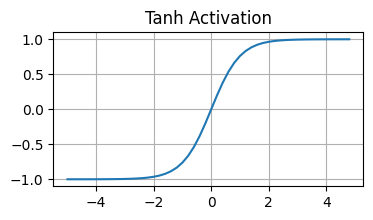

In [24]:
_num = np.arange(-5, 5, 0.2)
plt.figure(figsize=(4, 2))
plt.plot(_num, np.tanh(_num))
plt.title("Tanh Activation")
plt.grid()

##### Calculate Forward Pass and Backward Pass with Micrograd

w0.grad: -1.500000004284097


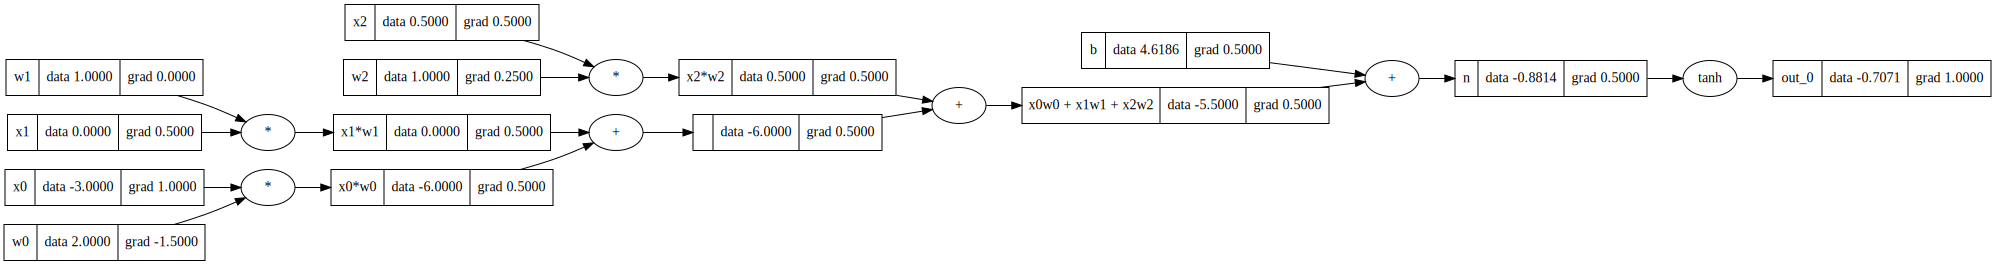

In [138]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass
# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'

# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
print(f'w0.grad: {w0.grad}')
draw_dot(out_0)

##### Check Backward Pass Gradient Calculation: d(output) / d(x0)

In [139]:
h = 0.000001
w0 += h  # increment x0 by h

# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_1 = n.tanh(); out_1.label = 'out_1'
out_grad = (out_1 - out_0) / h 

print(f'---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----')
print(f'out_1: {out_1.data:<12.10f}, out_0: {out_0.data:<12.10f}, d(out): {out_1.data-out_0.data:<12.10f}, d(w0): {h:<12.10f}, d(out)/d(w0): {(out_1.data-out_0.data)/h:<12.10f}')
print(f'd(out) / d(w0):             {out_grad.data:<12.10f}')
print(f'w0.grad from backward pass: {out_0_grad:<12.10f}')

---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----
out_1: -0.7071082802, out_0: -0.7071067802, d(out): -0.0000015000, d(w0): 0.0000010000, d(out)/d(w0): -1.4999968224
d(out) / d(w0):             -1.4999968224
w0.grad from backward pass: -1.5000000043


##### Check Calculation with Pytorch

In [67]:
import torch

In [140]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f}')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f}')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, define inputs and targets, initialize weights and biases 

In [141]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

In [143]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'len(n.parameters()): {len(n.parameters())}')
n.parameters()

len(n.parameters()): 41


[Value(data = 0.7873267075995096),
 Value(data = 0.28264816313702656),
 Value(data = -0.8684015948314985),
 Value(data = 0.02323647056832301),
 Value(data = 0.0021405014275279743),
 Value(data = -0.22377399521401053),
 Value(data = 0.6750914475419012),
 Value(data = 0.20132289500915257),
 Value(data = 0.9287483603130826),
 Value(data = 0.8503800610801633),
 Value(data = 0.15911471848607617),
 Value(data = 0.40485419231583664),
 Value(data = -0.6093288132069568),
 Value(data = 0.6830429695913582),
 Value(data = -0.6506469076359516),
 Value(data = 0.5002977001875062),
 Value(data = -0.582806077304602),
 Value(data = 0.00481730242237699),
 Value(data = -0.9262098806321524),
 Value(data = -0.22292682097313055),
 Value(data = 0.8195826795179717),
 Value(data = 0.8315383832625862),
 Value(data = 0.8142623613228162),
 Value(data = -0.1263135161554505),
 Value(data = -0.35055854752213533),
 Value(data = -0.10697745180195617),
 Value(data = 0.01635885107204471),
 Value(data = 0.3752772809755784

#### ---- Start: Manual calculation of a forward pass ----

##### Transpose inputs xs

In [71]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get neural network's weights and biases matrices

In [72]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
neuron 0
w0:  0.2188894,   w0.grad:  0.0000000
w1:  0.7148999,   w1.grad:  0.0000000
w2:  0.4333685,   w2.grad:  0.0000000
b:  -0.5810447
b_mat:  [-0.5810446674163146]
neuron 1
w0: -0.9629271,   w0.grad:  0.0000000
w1:  0.3421236,   w1.grad:  0.0000000
w2:  0.1991534,   w2.grad:  0.0000000
b:  -0.7568472
b_mat:  [-0.5810446674163146, -0.7568472031590823]
neuron 2
w0: -0.7789264,   w0.grad:  0.0000000
w1: -0.0467433,   w1.grad:  0.0000000
w2: -0.9740169,   w2.grad:  0.0000000
b:  -0.8104291
b_mat:  [-0.5810446674163146, -0.7568472031590823, -0.8104290797347571]
neuron 3
w0:  0.5577067,   w0.grad:  0.0000000
w1: -0.3254468,   w1.grad:  0.0000000
w2: -0.3454287,   w2.grad:  0.0000000
b:  -0.7061335
b_mat:  [-0.5810446674163146, -0.7568472031590823, -0.8104290797347571, -0.7061335305683769]
----
layer: 1, neuron_cnt: 4
----
neuron 0
w0:  0.0230296,   w0.grad:  0.0000000
w1:  0.8004156,   w1.grad:  0.0000000
w2:  0.7551908,   w2.grad:  0.0000000
w3

In [73]:
print(f'type(w_mats): {type(w_mats)}')
print(f'type(w_mats[0]): {type(w_mats[0])}')
print(f'w_mats[0].shape: {w_mats[0].shape}')
print(f'w_mats[0]: {w_mats[0]}\n')
print(f'type(xs_mats): {type(xs_mats)}')
print(f'type(xs_mats[0]): {type(xs_mats[0])}')
print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats[0]: {xs_mats[0]}\n')
print(f'type(b_mats): {type(b_mats)}')
print(f'type(b_mats[0]): {type(b_mats[0])}')
print(f'b_mats[0].shape: {b_mats[0].shape}')
print(f'b_mats[0]: {b_mats[0]}\n')

type(w_mats): <class 'list'>
type(w_mats[0]): <class 'numpy.ndarray'>
w_mats[0].shape: (4, 3)
w_mats[0]: [[ 0.21888943  0.71489987  0.43336847]
 [-0.96292707  0.34212355  0.19915338]
 [-0.77892637 -0.04674328 -0.97401694]
 [ 0.55770666 -0.32544681 -0.34542873]]

type(xs_mats): <class 'list'>
type(xs_mats[0]): <class 'numpy.ndarray'>
xs_mats[0].shape: (2, 3)
xs_mats[0]: [[ 2.   3.  -1. ]
 [ 3.  -1.   0.5]]

type(b_mats): <class 'list'>
type(b_mats[0]): <class 'numpy.ndarray'>
b_mats[0].shape: (1, 4)
b_mats[0]: [[-0.58104467 -0.7568472  -0.81042908 -0.70613353]]



##### Calculation for a forward pass

<img src="..\karpathy\img\neural_mat.PNG">

In [74]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])
  output = np.tanh(np.matmul(weights, input) + bias)

  if verbose:
    print(f'layer: {layer}')
    print(f'weights:\n{weights}\n')
    # print(f'xs_mats_T[layer]:\n{xs_mats_T[layer]}\n')
    print(f'input:\n{input}\n')    
    print(f'bias:\n{bias}\n')
    print(f'output:\n{output}\n')    

yout = output[0]
ys = ys
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')

layer: 0
weights:
[[ 0.21888943  0.71489987  0.43336847]
 [-0.96292707  0.34212355  0.19915338]
 [-0.77892637 -0.04674328 -0.97401694]
 [ 0.55770666 -0.32544681 -0.34542873]]

input:
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

bias:
[[-0.58104467]
 [-0.7568472 ]
 [-0.81042908]
 [-0.70613353]]

output:
[[ 0.91671748 -0.39911181]
 [-0.95225976 -0.99916127]
 [-0.91119062 -0.99847012]
 [-0.21807292  0.80747112]]

layer: 1
weights:
[[ 0.02302959  0.80041559  0.75519077 -0.61528135]
 [-0.1086624   0.45748735 -0.57731679 -0.84292802]
 [ 0.04872865 -0.61891025 -0.76410834  0.38037848]
 [-0.58206068  0.55518053 -0.71041199 -0.0127889 ]]

input:
[[ 0.91671748 -0.39911181]
 [-0.95225976 -0.99916127]
 [-0.91119062 -0.99847012]
 [-0.21807292  0.80747112]]

bias:
[[-0.72001177]
 [-0.37668019]
 [-0.64822348]
 [-0.05584405]]

output:
[[-0.96507561 -0.99232898]
 [-0.19936797 -0.71366906]
 [ 0.53641479  0.77019359]
 [-0.43657843  0.31018206]]

layer: 2
weights:
[[ 0.08582207 -0.68077059 -0.39951862  0.8627

#### ---- End: Manual calculation of a forward pass ----

#### Micrograd results are same as manual calculation

In [75]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.2504571728301796, 0.8192554463903117]
ys:                 [1.0, -1.0]
loss_data:          3.8715048289825393


In [76]:
# initialize
# step = 0

In [77]:
learning_rate = 0.05

# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.2504571728301796), Value(data = 0.8192554463903117)]
step: 0, loss: 3.8715048289825393
-------
ypred: [Value(data = 0.48554200931192065), Value(data = 0.7707327833376594)]
step: 1, loss: 3.40016161416955
-------
ypred: [Value(data = 0.39014758199328364), Value(data = 0.6014109864894416)]
step: 2, loss: 2.9364371193977252
-------
ypred: [Value(data = 0.17724481851740315), Value(data = 0.27520826706622326)]
step: 3, loss: 2.303082213050501
-------
ypred: [Value(data = -0.0022009545497690933), Value(data = 0.020509428929388205)]
step: 4, loss: 2.045846247834254
-------
ypred: [Value(data = -0.007924817166299157), Value(data = -0.020306648485320444)]
step: 5, loss: 1.9757115000617829
-------
ypred: [Value(data = 0.013495653550262469), Value(data = -0.02925405593763035)]
step: 6, loss: 1.9155385134777652
-------
ypred: [Value(data = 0.03935794895221084), Value(data = -0.04055644676755123)]
step: 7, loss: 1.8433650820806098
-------
ypred: [Value(data = 0.07762589383792

ypred: [Value(data = 0.9735392121444528), Value(data = -0.9571036639538923)]
step: 154, loss: 0.002540268940116867
-------
ypred: [Value(data = 0.9736260337957477), Value(data = -0.9572613936917299)]
step: 155, loss: 0.0025221745625163437
-------
ypred: [Value(data = 0.9737119650992003), Value(data = -0.9574174397980072)]
step: 156, loss: 0.002504335212302003
-------
ypred: [Value(data = 0.9737970213630158), Value(data = -0.9575718318074906)]
step: 157, loss: 0.002486745545622114
-------
ypred: [Value(data = 0.9738812175273941), Value(data = -0.9577245985371479)]
step: 158, loss: 0.0024694003666966263
-------
ypred: [Value(data = 0.9739645681758577), Value(data = -0.9578757681083724)]
step: 159, loss: 0.002452294622729176
-------
ypred: [Value(data = 0.974047087546157), Value(data = -0.9580253679683766)]
step: 160, loss: 0.0024354233990270284
-------
ypred: [Value(data = 0.9741287895407684), Value(data = -0.9581734249107882)]
step: 161, loss: 0.0024187819143193295
-------
ypred: [Value

Text(0, 0.5, 'Loss')

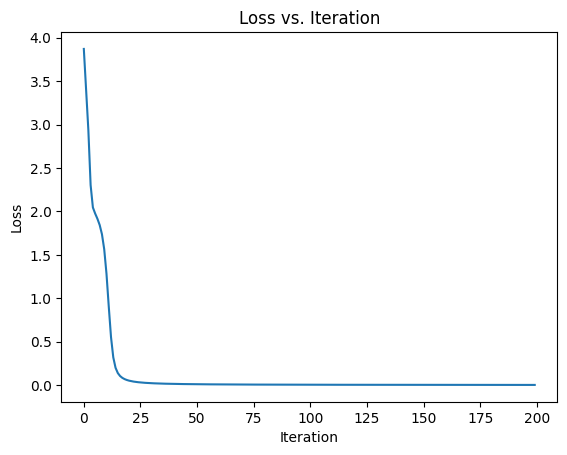

In [78]:

# Create a list of iterations
iterations = range(len(losses))

# Plot the loss as a function of iteration
plt.plot(iterations, losses)

# Add a title to the plot
plt.title('Loss vs. Iteration')

# Add labels to the x-axis and y-axis
plt.xlabel('Iteration')
plt.ylabel('Loss')